In [1]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="data/IMDB_5.csv")
dataset

D:\anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 250 examples [00:00, 6087.06 examples/s]


DatasetDict({
    train: Dataset({
        features: ['review_es', 'sentiment'],
        num_rows: 250
    })
})

In [2]:
df = dataset["train"].to_pandas()
df["sentiment"].unique()

array(['negative', 'positive'], dtype=object)

In [3]:
df

,review_es,sentiment
0,"¡Esta película es horrible, ni siquiera puedo ...",negative
1,Why do movie makers always go against the auth...,negative
2,No puedo creer que aquellos alabando esta pelí...,negative
3,Esta película realmente usó sus ubicaciones bi...,positive
4,"De manera extraña, esta película nunca llegó a...",positive
...,...,...
245,Obabakoak es un montón de cuentos con un único...,negative
246,Todo el mundo civilizado por ahora sabe que es...,positive
247,"Soy un enorme fan de las películas de guerra, ...",negative
248,"De acuerdo, aquí está el trato: si te ofenden ...",positive


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["sentiment"])

In [5]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("sentiment")
dataset = dataset.rename_column("review_es", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [22]:
from transformers import AutoTokenizer
checkpoint = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

D:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\spase\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [23]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [24]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 738.72 examples/s]


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # report_to="none",
)

In [26]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [30]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.696692,0.411578


TrainOutput(global_step=13, training_loss=0.7048342044536884, metrics={'train_runtime': 931.2058, 'train_samples_per_second': 0.215, 'train_steps_per_second': 0.014, 'total_flos': 51857544567360.0, 'train_loss': 0.7048342044536884, 'epoch': 1.0})

In [32]:
trainer.evaluate()

{'eval_loss': 0.6966917514801025,
 'eval_f1': 0.41157847127996383,
 'eval_runtime': 33.2513,
 'eval_samples_per_second': 1.504,
 'eval_steps_per_second': 0.12,
 'epoch': 1.0}

In [33]:
predictions = trainer.predict(tokenized_dataset["test"])

In [34]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.47      0.95      0.63        22
           1       0.80      0.14      0.24        28

    accuracy                           0.50        50
   macro avg       0.63      0.55      0.43        50
weighted avg       0.65      0.50      0.41        50



Text(0.5, 1.0, 'Confusion Matrix')

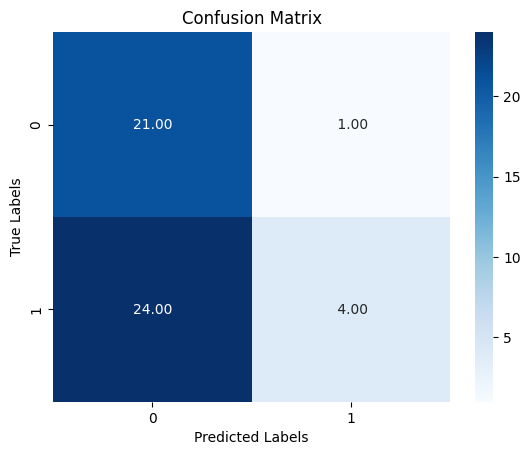

In [37]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Невронска мрежа

In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [92]:
df

,review_es,sentiment
0,"¡Esta película es horrible, ni siquiera puedo ...",negative
1,Why do movie makers always go against the auth...,negative
2,No puedo creer que aquellos alabando esta pelí...,negative
3,Esta película realmente usó sus ubicaciones bi...,positive
4,"De manera extraña, esta película nunca llegó a...",positive
...,...,...
243,No soy un gran fanático de Rajnikant en primer...,negative
244,"Verdaderamente una película repugnante, vil, c...",negative
245,Obabakoak es un montón de cuentos con un único...,negative
246,Todo el mundo civilizado por ahora sabe que es...,positive


<Axes: xlabel='sentiment'>

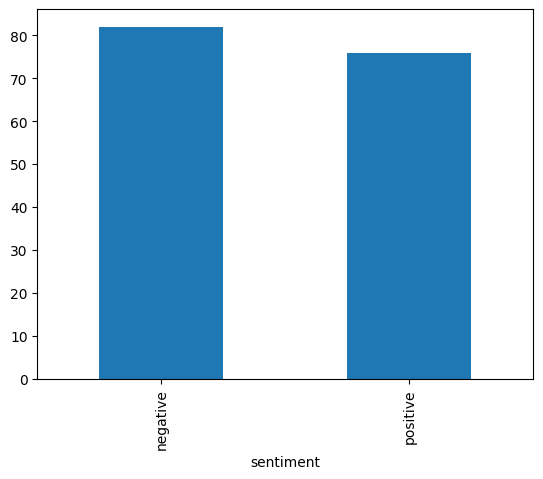

In [93]:
df["sentiment"].value_counts().plot.bar()

<Axes: ylabel='Frequency'>

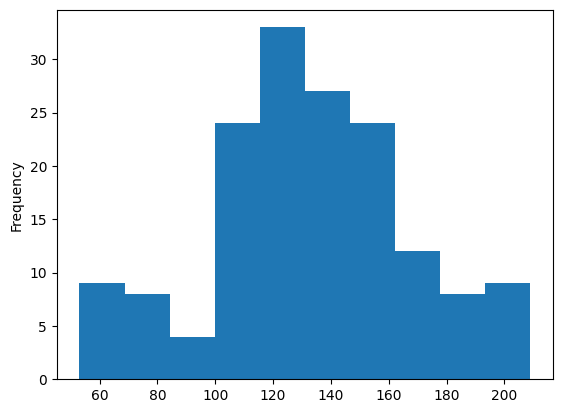

In [94]:
df["review_es"].str.split(" ").apply(len).plot.hist()

<Axes: >

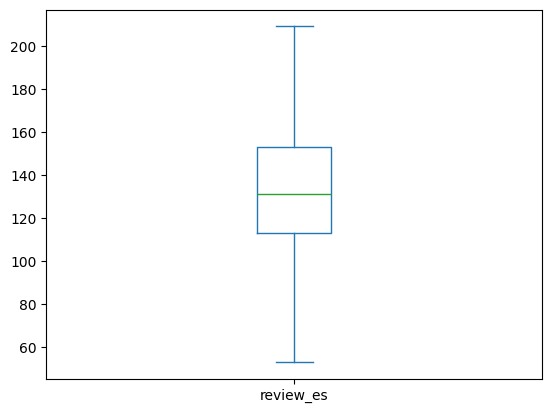

In [95]:
df["review_es"].str.split().apply(len).plot.box()

In [96]:
df = df[df["review_es"].str.split().apply(len) < 420].copy(deep=True)
df

,review_es,sentiment
0,"¡Esta película es horrible, ni siquiera puedo ...",negative
1,Why do movie makers always go against the auth...,negative
2,No puedo creer que aquellos alabando esta pelí...,negative
3,Esta película realmente usó sus ubicaciones bi...,positive
4,"De manera extraña, esta película nunca llegó a...",positive
...,...,...
243,No soy un gran fanático de Rajnikant en primer...,negative
244,"Verdaderamente una película repugnante, vil, c...",negative
245,Obabakoak es un montón de cuentos con un único...,negative
246,Todo el mundo civilizado por ahora sabe que es...,positive


<Axes: >

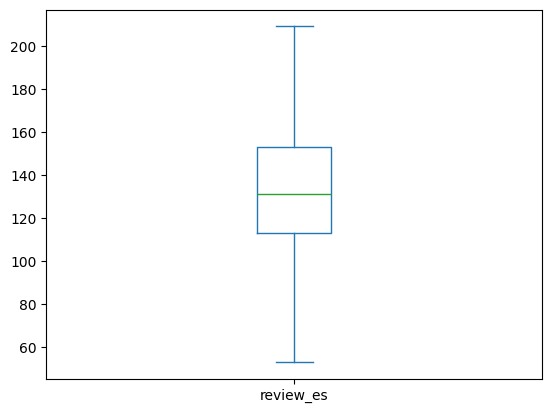

In [97]:
df["review_es"].str.split().apply(len).plot.box()

In [98]:
df = df[df["review_es"].str.split().apply(len) < 350].copy(deep=True)
df

,review_es,sentiment
0,"¡Esta película es horrible, ni siquiera puedo ...",negative
1,Why do movie makers always go against the auth...,negative
2,No puedo creer que aquellos alabando esta pelí...,negative
3,Esta película realmente usó sus ubicaciones bi...,positive
4,"De manera extraña, esta película nunca llegó a...",positive
...,...,...
243,No soy un gran fanático de Rajnikant en primer...,negative
244,"Verdaderamente una película repugnante, vil, c...",negative
245,Obabakoak es un montón de cuentos con un único...,negative
246,Todo el mundo civilizado por ahora sabe que es...,positive


<Axes: >

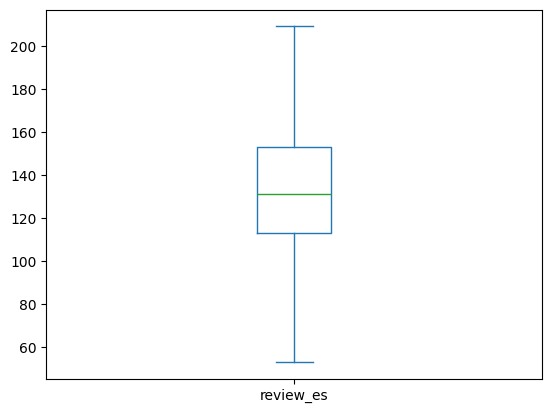

In [99]:
df["review_es"].str.split().apply(len).plot.box()

In [100]:
df = df[df["review_es"].str.split().apply(len) < 210].copy(deep=True)
df

,review_es,sentiment
0,"¡Esta película es horrible, ni siquiera puedo ...",negative
1,Why do movie makers always go against the auth...,negative
2,No puedo creer que aquellos alabando esta pelí...,negative
3,Esta película realmente usó sus ubicaciones bi...,positive
4,"De manera extraña, esta película nunca llegó a...",positive
...,...,...
243,No soy un gran fanático de Rajnikant en primer...,negative
244,"Verdaderamente una película repugnante, vil, c...",negative
245,Obabakoak es un montón de cuentos con un único...,negative
246,Todo el mundo civilizado por ahora sabe que es...,positive


<Axes: >

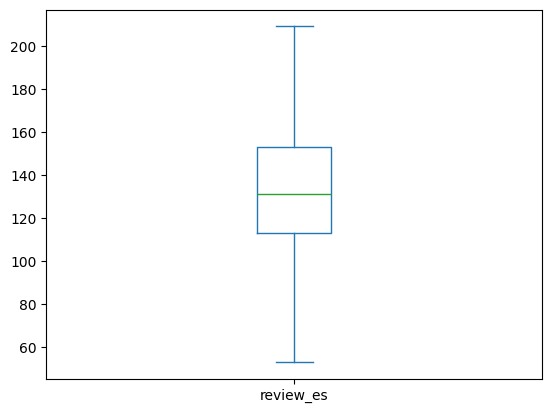

In [101]:
df["review_es"].str.split().apply(len).plot.box()

In [102]:
df = df[df["review_es"].str.split().apply(len) > 50].copy(deep=True)
df

,review_es,sentiment
0,"¡Esta película es horrible, ni siquiera puedo ...",negative
1,Why do movie makers always go against the auth...,negative
2,No puedo creer que aquellos alabando esta pelí...,negative
3,Esta película realmente usó sus ubicaciones bi...,positive
4,"De manera extraña, esta película nunca llegó a...",positive
...,...,...
243,No soy un gran fanático de Rajnikant en primer...,negative
244,"Verdaderamente una película repugnante, vil, c...",negative
245,Obabakoak es un montón de cuentos con un único...,negative
246,Todo el mundo civilizado por ahora sabe que es...,positive


<Axes: >

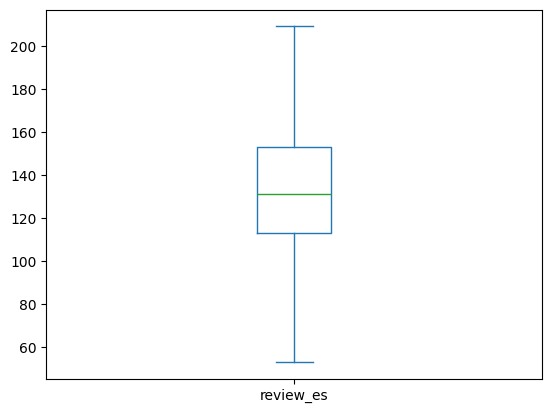

In [103]:
df["review_es"].str.split().apply(len).plot.box()

<Axes: ylabel='Frequency'>

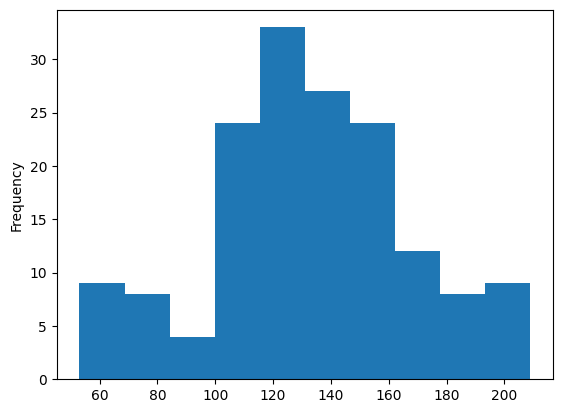

In [104]:
df["review_es"].str.split().apply(len).plot.hist()

In [105]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [106]:
vocabulary = get_vocabulary(df["review_es"].tolist())

In [107]:
len(vocabulary)

6928

In [108]:
max_vocabulary_size = 6400

In [109]:
X, y = df["review_es"], pd.get_dummies(df["sentiment"])

In [110]:
num_classes = y.shape[1]
num_classes

2

In [111]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [112]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

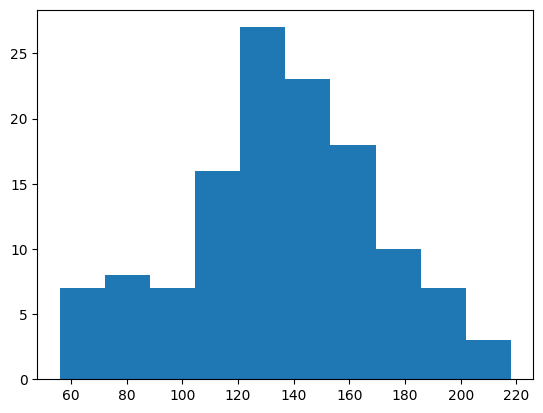

In [113]:
plt.hist([len(tokens) for tokens in train_X]);

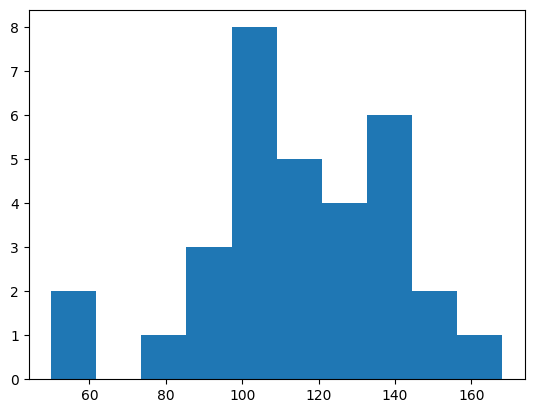

In [114]:
plt.hist([len(tokens) for tokens in test_X]);

In [115]:
maxlen = 180

In [116]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [117]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="sigmoid")
])

In [118]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [119]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=8)

Epoch 1/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - f1_score: 0.4577 - loss: 0.6930 - precision: 0.5263 - recall: 0.3085 - val_f1_score: 0.4052 - val_loss: 0.6932 - val_precision: 0.4800 - val_recall: 0.4615
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - f1_score: 0.7572 - loss: 0.6920 - precision: 0.6570 - recall: 0.6365 - val_f1_score: 0.5125 - val_loss: 0.6932 - val_precision: 0.5278 - val_recall: 0.7308
Epoch 3/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - f1_score: 0.8855 - loss: 0.6904 - precision: 0.7849 - recall: 0.9058 - val_f1_score: 0.4319 - val_loss: 0.6931 - val_precision: 0.5152 - val_recall: 0.6538
Epoch 4/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - f1_score: 0.8426 - loss: 0.6890 - precision: 0.8104 - recall: 0.9035 - val_f1_score: 0.4583 - val_loss: 0.6930 - val_precision: 0.5833 - val_recall: 0.5385
Epoch 5/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - f1_score: 0.9270 - loss: 0.6869 - precision: 0.9425 - recall: 0.9102 - val_f1_score: 0.4808 - val_loss: 0.6930 - val_prec

In [120]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 180, 32)             │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 180, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 90, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 90, 16)              │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 45, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 695,576 (2.65 MB)

 Trainable params: 231,858 (905.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 463,718 (1.77 MB)

<Axes: >

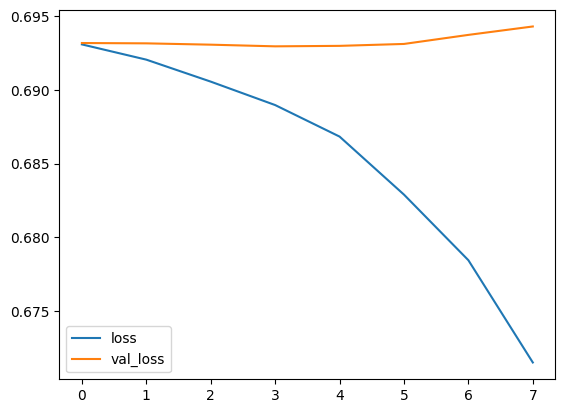

In [121]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [122]:
preds = model.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


In [123]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [124]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.25      0.08      0.12        12

    accuracy                           0.56        32
   macro avg       0.43      0.47      0.42        32
weighted avg       0.47      0.56      0.49        32



Text(0.5, 1.0, 'Confusion Matrix')

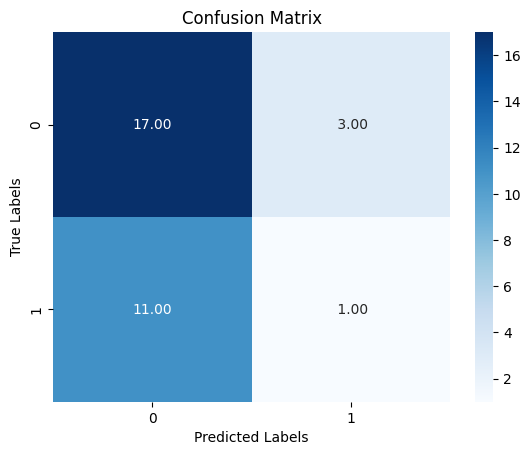

In [125]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")